<div align='center'  ><img width=200px height=200px src="mindflow.png"></div>

#  Distract your Attention Network

Source : https://arxiv.org/pdf/2109.07270.pdf

### Fondements théoriques

Deux problèmes fondamentaux pour notre cas d'usage de la *Facial Expression Recognition* (FER):

1. Comme on l'a vu avec notre modèle précedent, beaucoup d'emotions partagent les mêmes expressions faciales sous-jacentes. La faculté de differencier entre elles tient souvent à des subtilités ( micro-expressions).
2. Les émotions exprimées facialement solicitent de nombreuses régions du visage simultanément ce qui nécessite une approche holistique permettant de consolider de nombreuses *features* locales.

Les DAN ont été proposés par Zhengyao Wen, Wenzhong Lin, Tao Wang*, Ge Xu de Minjiang University afin de répondre à ces deux impératifs.

![DAN](DAN.png)

Cette architecture se structure autour de trois composantes successives fondamentales :

1. **FCN - Features Clustering Network** : essentiellement un block CNN avec un objectif d'apprentissage dit *large margin*.
    Cet objectif, correspondant à l'Affinity Loss permet de maximiser la séparabilité entre les classes d'émotions. L'idée est 
    d'augmenter, simulaténement, la distance inter-classe tout en diminuant la distance intra-classe. 
    Le resultat de cette étapes est un ensemble de features map assez robustes.
    
2. **MAN - Multi-head cross Attention Network** : Fully Connected Network instantiés plusieurs fois et qui se concentre sur de multiples regions du visages afin de construire simultanément les attentions maps (AM) correspondantes.

3. **AFN - Attention Fusion Network** : "distrait" les attention maps précedente sur d'autres localisation (pertubation spatiale) afin de consolider l'ensemble des ces AMs en une seule refletant la representation globale que se fait le réseau.

Enfin le DAN se termine avec une classification head standard.


### Application au Affectnet dataset

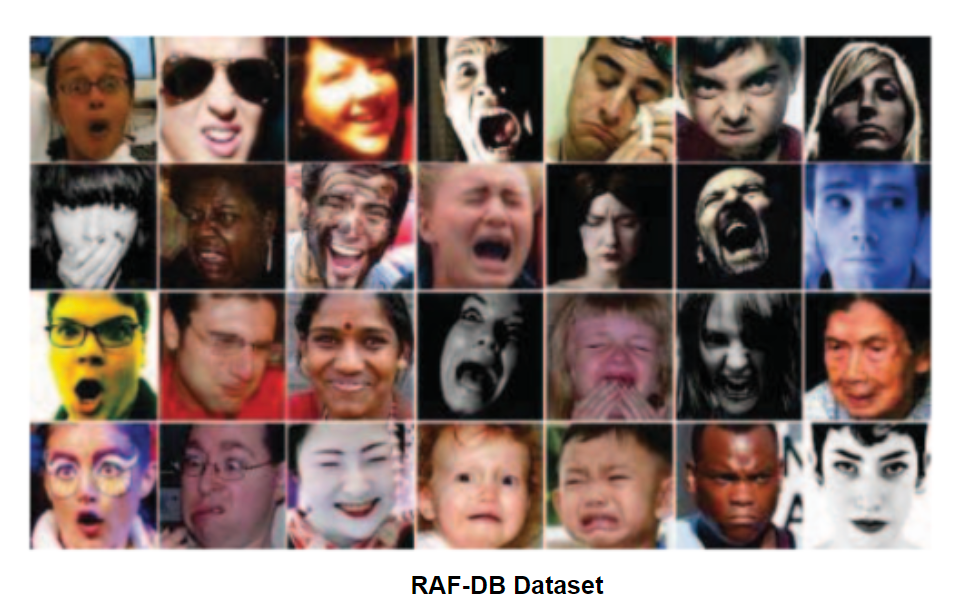

Sources :http://mohammadmahoor.com/affectnet/

La base de données Affectnet est une base de données d'expressions faciales à grande échelle contenant environ 1M images faciales très diverses téléchargées sur Internet. Sur la base de l'annotation du crowdsourcing, chaque image a été étiquetée. Les images de cette base de données présentent une grande variabilité en ce qui concerne l'âge, le sexe et l'origine ethnique des sujets, la position de la tête, les conditions d'éclairage, les occlusions (par exemple, lunettes, pilosité faciale ou auto-occlusion), les opérations de post-traitement (par exemple, divers filtres et effets spéciaux)

Ces images RGB ramenées à une dimension de 224 x 224 px sont classées en 8 catégories d'émotions dans notre version :

* 0=neutral
* 1=happy
* 2=sad
* 3=surprise
* 4=fear
* 5=disgust
* 6=anger
* 7=contempt



#### Résultats du papier

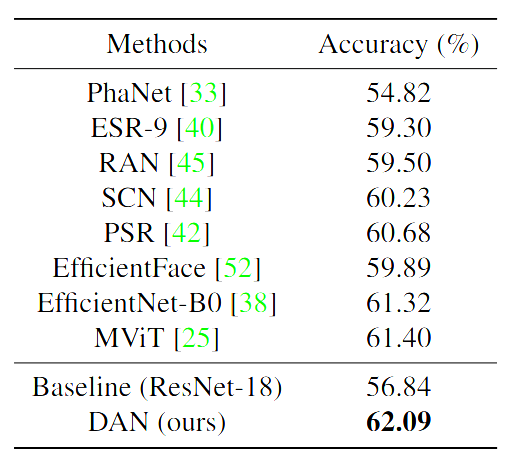

### Implementation du DAN

Cette partie se base sur le code mis à disposition par les chercheurs du papier en présences.
Des adaptations ont étés faites afin de faire fonctionner le code pour notre cas d'usage.

In [9]:
import torch
from torchvision import transforms

In [10]:
from torch import nn
from torch.nn import functional as F
import torch
import torch.nn.init as init
from torchvision import models


class DAN(nn.Module):
    def __init__(self, num_class=7,num_head=4, pretrained=True):
        super(DAN, self).__init__()
        
        resnet = models.resnet18(pretrained)
        
        if pretrained:
            checkpoint = torch.load('./models/resnet18_msceleb.pth')
            resnet.load_state_dict(checkpoint['state_dict'],strict=True)

        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.num_head = num_head
        for i in range(num_head):
            setattr(self,"cat_head%d" %i, CrossAttentionHead())
        self.sig = nn.Sigmoid()
        self.fc = nn.Linear(512, num_class)
        self.bn = nn.BatchNorm1d(num_class)


    def forward(self, x):
        x = self.features(x)
        heads = []
        for i in range(self.num_head):
            heads.append(getattr(self,"cat_head%d" %i)(x))
        
        heads = torch.stack(heads).permute([1,0,2])
        if heads.size(1)>1:
            heads = F.log_softmax(heads,dim=1)
            
        out = self.fc(heads.sum(dim=1))
        out = self.bn(out)
   
        return out, x, heads

class CrossAttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = SpatialAttention()
        self.ca = ChannelAttention()
        self.init_weights()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    def forward(self, x):
        sa = self.sa(x)
        ca = self.ca(sa)

        return ca


class SpatialAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
        )
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
        )
        self.conv_1x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(1,3),padding=(0,1)),
            nn.BatchNorm2d(512),
        )
        self.conv_3x1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3,1),padding=(1,0)),
            nn.BatchNorm2d(512),
        )
        self.relu = nn.ReLU()


    def forward(self, x):
        y = self.conv1x1(x)
        y = self.relu(self.conv_3x3(y) + self.conv_1x3(y) + self.conv_3x1(y))
        y = y.sum(dim=1,keepdim=True) 
        out = x*y
        
        return out 

class ChannelAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 512),
            nn.Sigmoid()    
        )


    def forward(self, sa):
        sa = self.gap(sa)
        sa = sa.view(sa.size(0),-1)
        y = self.attention(sa)
        out = sa * y
        
        return out

In [11]:
from PIL import Image as Image_p

In [12]:
class Model():
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.data_transforms = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                ])
        self.labels = ['neutral', 'happy', 'sad', 'surprise', 'fear', 'disgust', 'anger', 'contempt']

        self.model = DAN(num_head=4, num_class=8, pretrained=False)
        checkpoint = torch.load('affecnet8_epoch5_acc0.6209.pth',
            map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'],strict=True)
        self.model.to(self.device)
        self.model.eval()
    
    def predict(self, path):
        img = Image_p.open(path).convert('RGB')
        img = self.data_transforms(img)
        img = img.view(1,3,224,224)
        img = img.to(self.device)

        with torch.set_grad_enabled(False):
            out, _, _ = self.model(img)
            out = F.softmax(out,dim=len(out))
            _, pred = torch.max(out,1)
            index = int(pred)
            label = self.labels[index]

            return index, label, float(_), out.tolist()[0]

In [13]:
class Model():
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.data_transforms = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                ])
        self.labels = ['neutral', 'happy', 'sad', 'surprise', 'fear', 'disgust', 'anger', 'contempt']

        self.model = DAN(num_head=4, num_class=8, pretrained=False)
        checkpoint = torch.load('affecnet8_epoch5_acc0.6209.pth',
            map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'],strict=True)
        self.model.to(self.device)
        self.model.eval()
    
    def predict(self, img):
        #img = Image_p.open(path).convert('RGB')
        
        img = Image_p.fromarray(img).convert('RGB')
        
        img = self.data_transforms(img)
        img = img.view(1,3,224,224)
        img = img.to(self.device)

        with torch.set_grad_enabled(False):
            out, _, _ = self.model(img)
            out = F.softmax(out,dim=len(out))
            _, pred = torch.max(out,1)
            index = int(pred)
            label = self.labels[index]

            return index, label, float(_), out

In [14]:
raf_dan_model = Model()

In [15]:
raf_dan_model.labels

['neutral', 'happy', 'sad', 'surprise', 'fear', 'disgust', 'anger', 'contempt']

In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

In [17]:

stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)

cp = np.array(None)

def view(button):
    crop_param = (3*20, 3*20)
    haar_cascade = cv2.CascadeClassifier('./data/models/haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    i = 0
    while cap.isOpened():
        r , frame = cap.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        #r, frame = cv2.imencode('.jpeg', frame)


        # Par défaut, la frame est en RGB, on la converti en image "niveaux de gris" 
        # cela permet d'avoir une plus grande efficience computationnelle et de meilleurs résultats pour
        # l'algorithme de Viola Jones
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        #cv2.imshow('Grayscale', gray_frame)
            
        #Extraction des visages present sur la gray_frame grace à l'algorithme de HAAR précedement chargé, nous retourne un itérable de coordonnées spatiales dans la gray_frame correspondantes
        
        visages = haar_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5,
                    minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

            # Grace à chaque coordonnées des visages detectés, on leur applique le rognage spécifié precedemment et les envoient dans le réseau de neurones pour detection
        for visage_coordinates in visages:

            # Extraction des coordonées du visage en cours de traitementn, h étant la hauteur et w la largeur du rectangle correspondant au visage
            X, Y, w, h = visage_coordinates

            # Rognage et extraction de l'image 'niveau de gris' traité du visage en cours de traitement
            x_d, y_d = crop_param
            x1, x2, y1, y2 = (X - x_d, X + w + x_d, Y - y_d, Y + h + y_d)
                   
            
            
            
                
            try:
                
                cp_visage = frame[y1:y2, x1:x2]
                #cp_visage = cv2.resize(cp_visage, dsize=(48*1, 48*1))
                #cv2.imwrite('test.jpg', cp_visage)
                emotion_idx, emotion_class, emotion_prob = raf_dan_model.predict(cp_visage)
                #print(emotion_idx, emotion_class, emotion_prob)
                
                #cv2.putText(frame,emotion_class,(10,10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
                #cv2.putText(frame,'TEST',(X, Y),cv2.FONT_HERSHEY_SIMPLEX,0.45,(0, 128, 0),2)
                #cv2.putText(frame,str(emotion_class),(X, Y),cv2.FONT_HERSHEY_SIMPLEX,0.45,(0, 128, 0),2)
                #cv2.rectangle(img=frame,pt1=(X, Y),pt2=(X + w, Y + h),color=(0, 0, 0),thickness=10)
                #cv2.putText(frame,str(emotion_class) + ' Probability  ' + str(round(emotion_prob,3)*100)+"%",(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255, 255, 255),3)

                cp = cp_visage.copy()
            except:
                pass


        
        
        try:
            cv2.rectangle(img=frame,pt1=(x1 +10, y1+10),pt2=(x2-10, y2-10),color=(127, 127, 127),thickness=3)
            cv2.putText(frame,emotion_class,(50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (127, 127, 127), 2, cv2.LINE_AA)
            #cv2.putText(frame,str(emotion_prob)[:3],(50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (127, 127, 127), 0.5, cv2.LINE_AA)
            r, frame = cv2.imencode('.jpeg', frame)
        except:
            pass

        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

None